In [1]:
%matplotlib inline

import dlc_practical_prologue as prologue
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import random
from models import FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX
import timeit

In [2]:
def load():

    # Load the data
    size = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(size)

    #normalization
    #check https://stats.stackexchange.com/questions/174823/
    mu, std = train_input.mean(), train_input.std()
    train_input, test_input = train_input.sub(mu).div(std), test_input.sub(mu).div(std)

    #split the images
    train_input1, train_input2 = train_input[:, 0, :, :], train_input[:, 1, :, :] 
    test_input1, test_input2 = test_input[:, 0, :, :], test_input[:, 1, :, :] 

    #split the number pairs
    train_classes1, train_classes2 = train_classes[:, 0], train_classes[:, 1]
    test_classes1, test_classes2 = test_classes[:, 0], test_classes[:, 1]
    
    list = [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target]
    
    return list


In [3]:
 [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()

In [4]:
# Parameters

batchSize = 500

In [5]:
"""
:param model: a dict encapsulating the model and its properties
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a dict encapsulating the model history
"""
def train_model(model, inps1, inps2, digits1, digits2, targets):
    
    epochs = model['nb_epochs']
    batch_size = model['batch_size']
    criterion = model['criterion']
    optimizer = model['optimizer']
    mdl = model['model']
      
    #  a dict to return whatever value we want to return
    #  e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    
    loss_history = [] #a list to keep track of the losses at each epoch
    for e in range(epochs):
        train_indices = random.sample(range(inps1.size(0)), batch_size)  # pick a minibatch   
        d1, d2, pred = mdl(inps1[train_indices], inps2[train_indices])   # run through the network
        pred_loss =  criterion(pred.view(-1, 2), targets[train_indices]) # loss due to boolean value
            
        #this is where auxillary loss happens depending on the model.
        #if a model returns the digit information, it is taken into account in the backprop.
        #if there is no digit info only loss we have is the one due to boolean above
        if d1 is not None:
            pred_loss += criterion(d1.view(-1, 10), digits1[train_indices])
            pred_loss += criterion(d2.view(-1, 10), digits2[train_indices])
            pred_loss /= 3
            
        loss = pred_loss.item() #magnitude of the loss
        mdl.zero_grad()         #reset the gradients for this epoch
        pred_loss.backward()    #calculate the gradients
        optimizer.step()        #update the weights
            

        loss_history.append(loss) #record the loss 
        
    model_history['loss_history'] = loss_history
    return model_history

In [6]:
"""
:param model: a dict encapsulating the model and its properties
:param inps1_tr: lhs of image pairs from training set
:param inps2_tr: rhs of image pairs from training set
:param inps1_te: lhs of image pairs from test set
:param inps2_te: rhs of image pairs from test set
:param digits1_tr: classes of inps1 from training set
:param digits2_tr: classes of inps2 from training set
:param digits1_te: classes of inps1 from test set
:param digits2_te: classes of inps2 from test set
:param targets_tr: final boolean value indicating whether lhs <= rhs from training set
:param targets_te: final boolean value indicating whether lhs <= rhs from test set
:return: a dict encapsulating the model history
"""
def train_model_compute_test_loss(model, inps1_tr, inps2_tr, inps1_te, inps2_te,\
                                  digits1_tr, digits2_tr, digits1_te, digits2_te, targets_tr, targets_te):
    
    epochs = model['nb_epochs']
    batch_size = model['batch_size']
    criterion = model['criterion']
    optimizer = model['optimizer']
    mdl = model['model']
      
    #  a dict to return whatever value we want to return
    #  e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    
    train_loss_history = [] #a list to keep track of the losses at each epoch
    test_loss_history = []
    for e in range(epochs):
        # compute the training loss
        indices_tr = random.sample(range(inps1_tr.size(0)), batch_size)  # pick a minibatch   
        indices_te = random.sample(range(inps1_te.size(0)), batch_size)
        d1_tr, d2_tr, pred_tr = mdl(inps1_tr[indices_tr], inps2_tr[indices_tr])   # run through the network
        d1_te, d2_te, pred_te = mdl(inps1_te[indices_te], inps2_te[indices_te])
        pred_loss_tr =  criterion(pred_tr.view(-1, 2), targets_tr[indices_tr]) # loss due to boolean value
        pred_loss_te =  criterion(pred_te.view(-1, 2), targets_te[indices_te])
            
        #this is where auxillary loss happens depending on the model.
        #if a model returns the digit information, it is taken into account in the backprop.
        #if there is no digit info only loss we have is the one due to boolean above
        if d1_tr is not None:
            pred_loss_tr += criterion(d1_tr.view(-1, 10), digits1_tr[indices_tr])
            pred_loss_tr += criterion(d2_tr.view(-1, 10), digits2_tr[indices_tr])
            pred_loss_tr /= 3
        
            pred_loss_te += criterion(d1_te.view(-1, 10), digits1_te[indices_te])
            pred_loss_te += criterion(d2_te.view(-1, 10), digits2_te[indices_te])
            pred_loss_te /= 3
            
        loss_tr = pred_loss_tr.item() #magnitude of the loss
        loss_te = pred_loss_te.item()
            
        mdl.zero_grad()         #reset the gradients for this epoch
        pred_loss_tr.backward()    #calculate the gradients
        optimizer.step()        #update the weights

        train_loss_history.append(loss_tr) #record the train loss 
        test_loss_history.append(loss_te) #record the test loss
        
    model_history['train_loss_history'] = train_loss_history
    model_history['test_loss_history'] = test_loss_history
    return model_history

In [7]:
"""
:param model: a dict encapsulating the model and its properties
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def compute_nb_errors(model, inps1, inps2, digits1, digits2, targets):
    n_samples = inps1.shape[0]
    
    d1,d2,pred = model(inps1, inps2)           # predict the digits + boolean
    _, indices = torch.max(pred.view(-1,2), 1) # torch.max returns the max value from the distribution and its corresponding index
    acc_target = (sum(indices == targets) / float(n_samples) * 100).item()  #calculate accuracy

    acc_d1, acc_d2 = 0, 0
    if d1 is not None: #the model returns digits if it makes use of aux loss. in this case we can report the accuracy of predicting the digits.
        _, indices1 = torch.max(d1.view(-1,10), 1)
        _, indices2 = torch.max(d2.view(-1,10), 1)
        acc_d1 += (sum(indices1 == digits1) / float(n_samples) * 100).item()
        acc_d2 += (sum(indices2 == digits2) / float(n_samples) * 100).item()
    
    
    return (acc_target, acc_d1, acc_d2)

  

In [8]:
"""
:param model_constructor: constructor for the model
:param optimizer_name: 'sgd' or 'adam'
:param lr: learning rate
:param batch_size: batch_size.
:return: an encapsulated model ready for the training
"""
def model_selector(model_constructor, optimizer_name, lr, batch_size):
    model = dict()
    model['model'] = model_constructor()
    model['criterion'] = nn.CrossEntropyLoss()
    model['nb_epochs'] = 25
    model['batch_size'] = batch_size
    if(optimizer_name == 'sgd'):
        model['optimizer'] = torch.optim.SGD(model['model'].parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'adam':
        model['optimizer'] =  torch.optim.Adam(model['model'].parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    return model

In [9]:
"""
:param inps1: lhs of image pairs
:param inps2: rhs of image pairs
:param digits1: classes of inps1 
:param digits2: classes of inps2
:param targets: final boolean value indicating whether lhs <= rhs
:return: a triplet indicating the accuracies ordered as (boolean,lhs,rhs)
"""
def cross_val_score(inps1, inps2, digits1, digits2, targets, model_constructor, optimizer_name, lr, batch_size, k_folds=5):
    len_train = inps1.shape[0]
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    acc_target, acc_d1, acc_d2  = 0,0,0
    for k in range(k_folds):
        model = model_selector(model_constructor, optimizer_name, lr, batch_size)  # init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        #train the model with k-1 training fold
        history = train_model(model, inps1[train_indices], inps2[train_indices], digits1[train_indices], digits2[train_indices], targets[train_indices])
        
        #compute the accuracy on 1 validation fold
        accs = compute_nb_errors(model['model'], inps1[val_indices], inps2[val_indices], digits1[val_indices], digits2[val_indices], targets[val_indices])
        
        acc_target += accs[0]
        acc_d1 += accs[1]
        acc_d2 += accs[2]
        print('fold=', k, ' loss = ', history['loss_history'][-1])
    return (acc_target / k_folds, acc_d1 /k_folds, acc_d2 /k_folds)




In [10]:
#dont run this unless you wanna tune the hyperparemeters for yourself.
models = [FNN, FNN_WS, FNN_WS_AUX, FNN_AUX, CNN, CNN_WS_AUX, CNN_WS, CNN_AUX]
batch_sizes = [800]
lrs = [0.001 * x for x in range(10, 25)]
opts = ['adam']

for m in models:
    for b in batch_sizes:
        for lr in lrs:
            for opt in opts:
                print(m, b, lr, opt)
                acc_t, acc_d1, acc_d2 = cross_val_score(train_input1, train_input2, train_classes1, train_classes2,  train_target, m, opt,lr,b, k_folds=5)
                print(acc_t, acc_d1, acc_d2)

<class 'models.FNN'> 800 0.01 adam


NameError: name 'train_input1' is not defined

In [10]:
def initialize_models():

    model_FNN = model_selector(FNN, 'adam', 0.02, batchSize)
    model_FNN_WS = model_selector(FNN_WS, 'adam', 0.017, batchSize)
    model_FNN_WS_AUX = model_selector(FNN_WS_AUX, 'adam', 0.014, batchSize)
    model_FNN_AUX = model_selector(FNN_AUX, 'adam', 0.014, batchSize)

    model_CNN = model_selector(CNN, 'adam', 0.012, batchSize)
    model_CNN_WS_AUX = model_selector(CNN_WS_AUX, 'adam', 0.018, batchSize)
    model_CNN_WS = model_selector(CNN_WS, 'adam', 0.017, batchSize)
    model_CNN_AUX = model_selector(CNN_AUX, 'adam', 0.017, batchSize)

    models = [model_FNN, model_FNN_WS, model_FNN_AUX, model_FNN_WS_AUX, model_CNN, model_CNN_WS, model_CNN_AUX, model_CNN_WS_AUX]
    return models

In [11]:
# performance
import statistics

modelMean = []
modelStd = []
timeMean = []
timeStd = []
models = initialize_models()
for m in range(len(models)):
    accs = []
    times = []
    for i in range(10):
        [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()
        models = initialize_models()
        start = timeit.default_timer()
        train_model(models[m], train_input1, train_input2, train_classes1, train_classes2, train_target)
        stop = timeit.default_timer()
        acc = compute_nb_errors(models[m]['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
        accs.append(acc[0])
        times.append(stop-start)
    modelMean.append(statistics.mean(accs))
    modelStd.append(statistics.pstdev(accs))
    timeMean.append(statistics.mean(times))
    timeStd.append(statistics.pstdev(times))

print("Accuracy means ", modelMean)
print("\nAccuracy standard deviations ", modelStd)
print("\nExecution time means ", timeMean)
print("\nExecution time standard deviations ", timeStd)

Accuracy means  [73.94000015258788, 74.39999847412109, 90.7099998474121, 92.21999969482422, 73.14000053405762, 73.6700008392334, 89.95999755859376, 90.91000061035156]

Accuracy standard deviations  [1.4368029347643692, 1.3535151064231492, 1.2037008349599292, 1.6928085915844702, 6.595331264965539, 6.639886211087048, 3.736895404205203, 3.3182661009927163]

Execution time means  [0.2607185126000012, 0.2169052903999983, 0.2760554143999997, 0.26122248819999927, 1.4097146592999976, 1.7068575448999979, 1.6119086908999989, 2.003708296000002]

Execution time standard deviations  [0.023443451277985028, 0.018308732097197553, 0.027269811286948706, 0.02392990064442718, 0.031020693306055582, 0.17576269847659987, 0.1234331125781744, 0.3624729949020252]


In [12]:
# optimized performance (to not load 10*nb models but only 10 times the datas)
import numpy

dixAccs = []
dixTimes = []
for i in range(10):
    [train_input1, train_input2, test_input1, test_input2, train_classes1, train_classes2, test_classes1, test_classes2, train_target, test_target] = load()
    models = initialize_models()
    accs = []
    times = [] 
    for m in models:
        start = timeit.default_timer()
        train_model(m, train_input1, train_input2, train_classes1, train_classes2, train_target)
        stop = timeit.default_timer()
        acc = compute_nb_errors(m['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
        accs.append(acc[0])
        times.append(stop-start)
    dixAccs.append(accs)
    dixTimes.append(times)

print("Accuracy means ", numpy.mean(dixAccs, axis = 0))
print("\nAccuracy standard deviations ", numpy.std(dixAccs, axis = 0))
print("\nExecution time means ", numpy.mean(dixTimes, axis = 0))
print("\nExecution time standard deviations ", numpy.std(dixTimes, axis = 0))

Accuracy means  [72.05       74.15999985 89.18000031 91.36999969 71.78000031 71.49000206
 89.44000015 92.59999924]

Accuracy standard deviations  [2.09964296 1.54803312 2.37225455 2.9866528  6.32025438 8.63486603
 2.84717267 1.52249972]

Execution time means  [0.27662342 0.24762713 0.28305138 0.26272834 1.513186   1.6886751
 1.54405831 1.48233515]

Execution time standard deviations  [0.01903124 0.02409855 0.01909844 0.0183814  0.1500469  0.50281
 0.11559523 0.10151331]


In [65]:
# Plots
n_training = 10

# Computing losses
histories = []
models_accuracies = []
for i in range(n_training):
    models = initialize_models()
    accuracies = []
    for m in range(len(models)):
        history = train_model_compute_test_loss(models[m], train_input1, train_input2, test_input1, test_input2, train_classes1,\
                                                train_classes2, test_classes1, test_classes2, train_target, test_target)
        acc_target, acc_d1, acc_d2 = compute_nb_errors(models[m]['model'], test_input1, test_input2, test_classes1, test_classes2, test_target)
        #print("\nAccuracy on target = ",acc_target)
        #print("Accuracy on digit 1 = ",acc_d1)
        #print("Accuracy on digit 2 = ",acc_d2)
        accuracies.append("%.2f" % acc_target)
        histories.append(history)
    models_accuracies.append(accuracies)
        
# Computing the mean loss
histories_mean = []
for m in range(len(models)):
    history = histories[m]
    histories_mean.append(history)
# Compute the sum of the losses
for n in range(1,n_training): 
    for m in range(len(models)):
        history = histories[n*8+m]
        histories_mean[m]['train_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['train_loss_history'],history['train_loss_history'])]
        histories_mean[m]['test_loss_history'] = [x + y for x, y in \
                                                   zip(histories_mean[m]['test_loss_history'],history['test_loss_history'])]
# Compute the average
for m in range(len(models)):
    histories_mean[m]['train_loss_history'] = [x/10 for x in histories_mean[m]['train_loss_history']]
    histories_mean[m]['test_loss_history'] = [x/10 for x in histories_mean[m]['test_loss_history']]
        
# Printing the accuracies
models_accuracies = [list(tup) for tup in zip(*models_accuracies)]
for c in range(len(curve_names)) :
    print("\n", curve_names[c], " Accuracies :", models_accuracies[c])
    
# Printing the mean loss to check the coherence with the accuracies
for c in range(len(curve_names)) :
    print("\n", curve_names[c], " Mean test loss :", sum(histories_mean[c]['train_loss_history'])/len(histories_mean[c]['train_loss_history']))


 FNN  Accuracies : ['71.00', '74.80', '73.60', '73.80', '74.10', '72.40', '74.00', '72.40', '73.00', '72.80']

 FNN_WS  Accuracies : ['74.60', '75.20', '75.70', '75.00', '74.90', '74.00', '74.70', '75.90', '74.70', '75.40']

 FNN_AUX  Accuracies : ['85.20', '86.70', '88.80', '87.10', '88.00', '88.00', '82.60', '87.30', '86.30', '89.40']

 FNN_WS_AUX  Accuracies : ['88.60', '88.00', '89.60', '77.10', '77.90', '88.90', '88.40', '89.00', '92.20', '81.90']

 CNN  Accuracies : ['74.60', '70.30', '74.70', '72.20', '73.00', '74.80', '68.70', '74.50', '75.80', '73.50']

 CNN_WS  Accuracies : ['74.70', '73.80', '76.90', '75.30', '74.90', '75.40', '75.60', '77.40', '74.50', '75.40']

 CNN_AUX  Accuracies : ['84.80', '92.10', '83.40', '88.60', '84.00', '88.40', '89.50', '88.80', '90.60', '88.40']

 CNN_WS_AUX  Accuracies : ['93.50', '88.30', '93.40', '86.10', '91.40', '91.60', '93.20', '91.80', '88.30', '87.90']

 FNN  Mean test loss : 0.598866187095642

 FNN_WS  Mean test loss : 0.6054171304702

In [66]:
#from scipy.ndimage.filters import gaussian_filter1d
#ySmoothed = gaussian_filter1d(y, sigma=2)

def plotLoss(histories, x_label, y_label, line_labels):
    train_losses = [hist['train_loss_history'] for hist in histories]
    test_losses = [hist['test_loss_history'] for hist  in histories]
    plt.figure(figsize=(10,8))
    for l,n in zip(train_losses,line_labels):
        plt.plot(l, label = n)
    for l,n in zip(test_losses,line_labels):
        plt.plot(l, '--', label = n+" Test")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


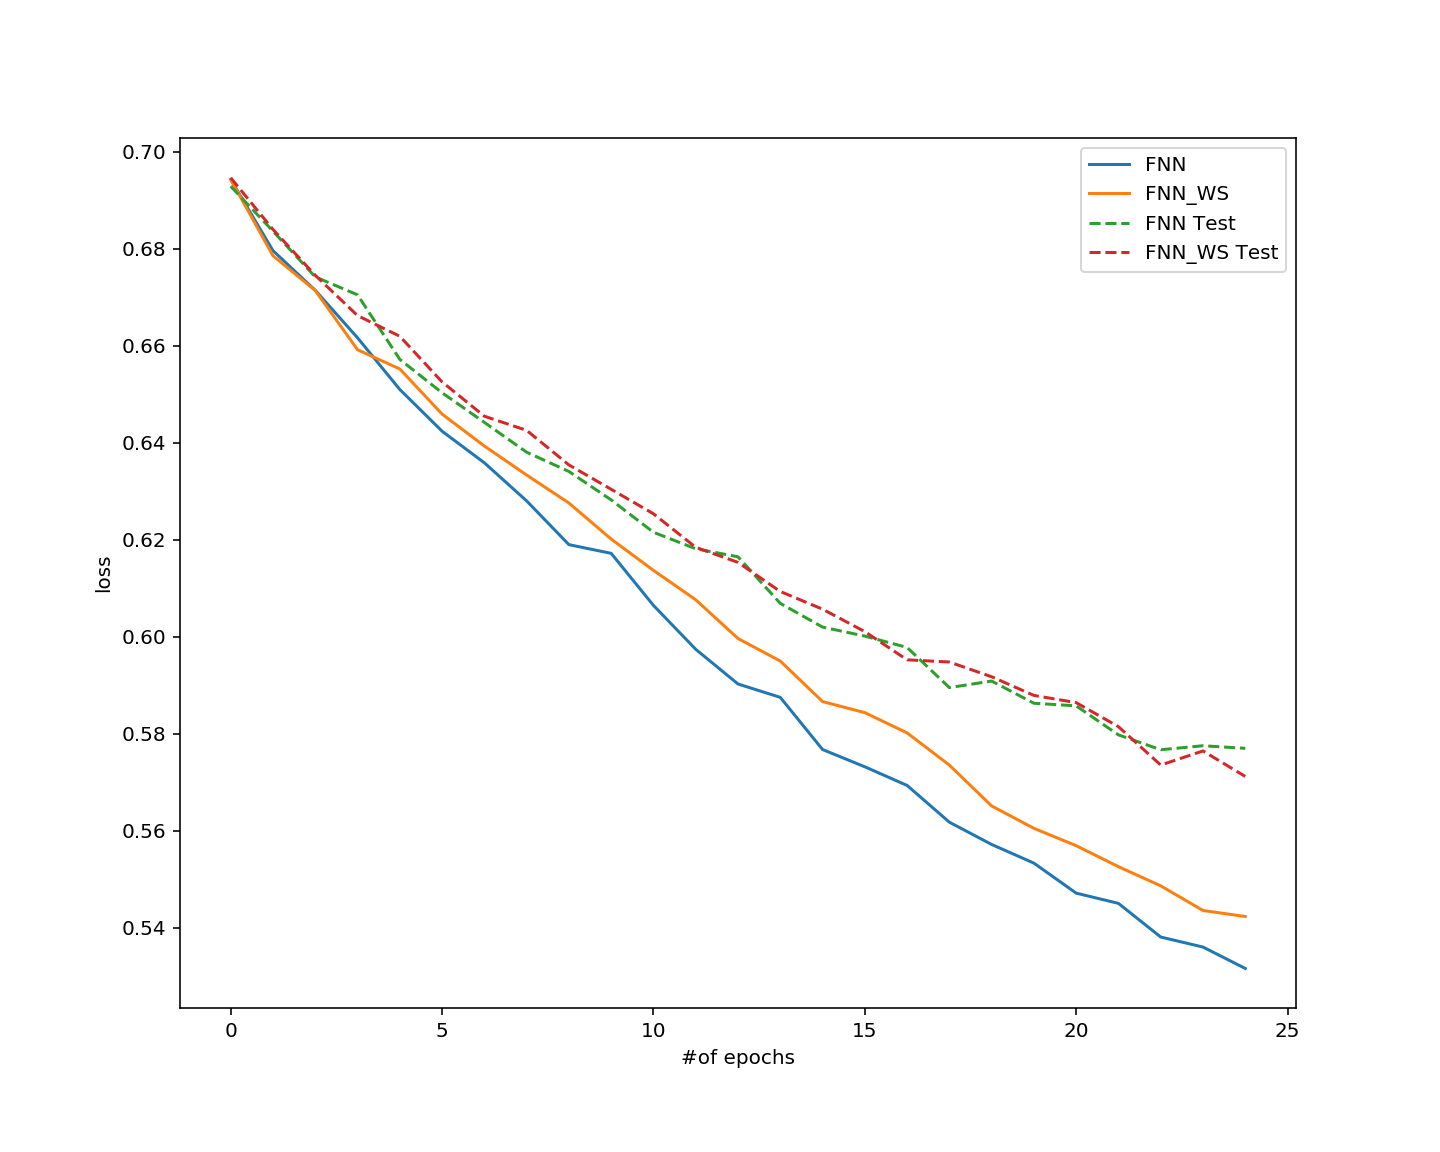

In [69]:
%matplotlib notebook
curve_names = [x['model'].__class__.__name__ for x in models]
plotLoss(histories_mean[:2], '#of epochs', 'loss', curve_names[:2])

<IPython.core.display.Javascript object>


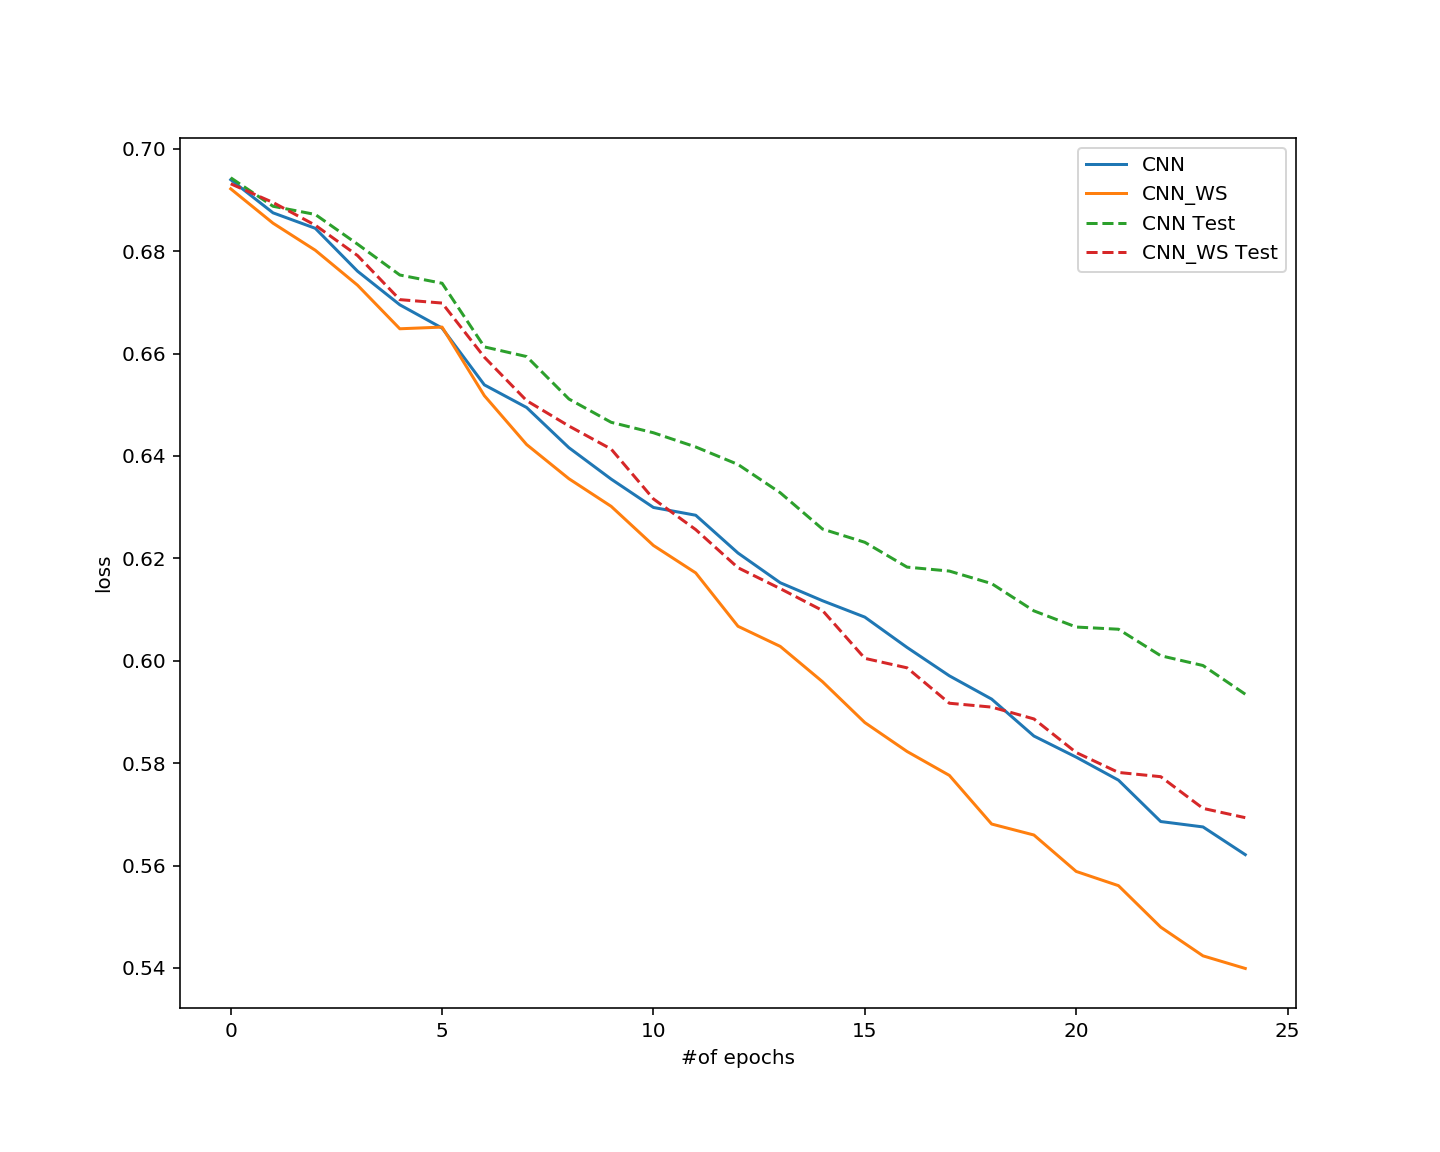

In [70]:
%matplotlib notebook
curve_names = [x['model'].__class__.__name__ for x in models]
plotLoss([histories[4]] + [histories[5]], '#of epochs', 'loss',[curve_names[4]] + [curve_names[5]])

<IPython.core.display.Javascript object>


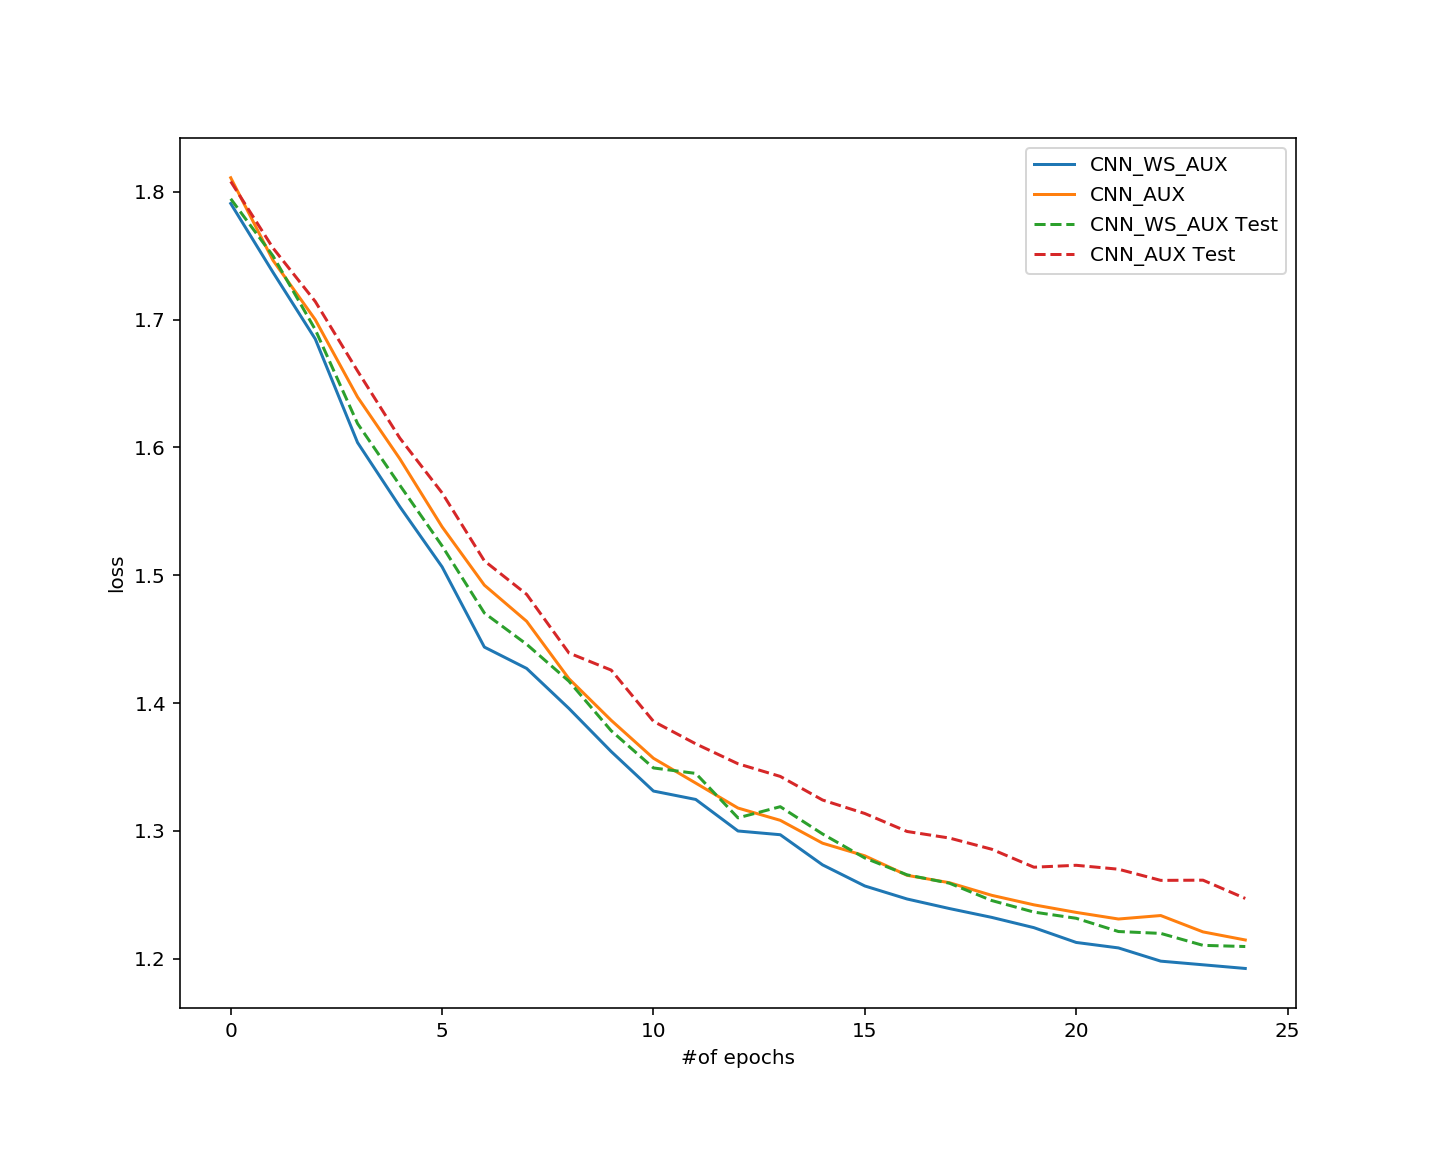

In [71]:
plotLoss([histories[7]] + [histories[6]], '#of epochs', 'loss',  [curve_names[7]] + [curve_names[6]])

<IPython.core.display.Javascript object>


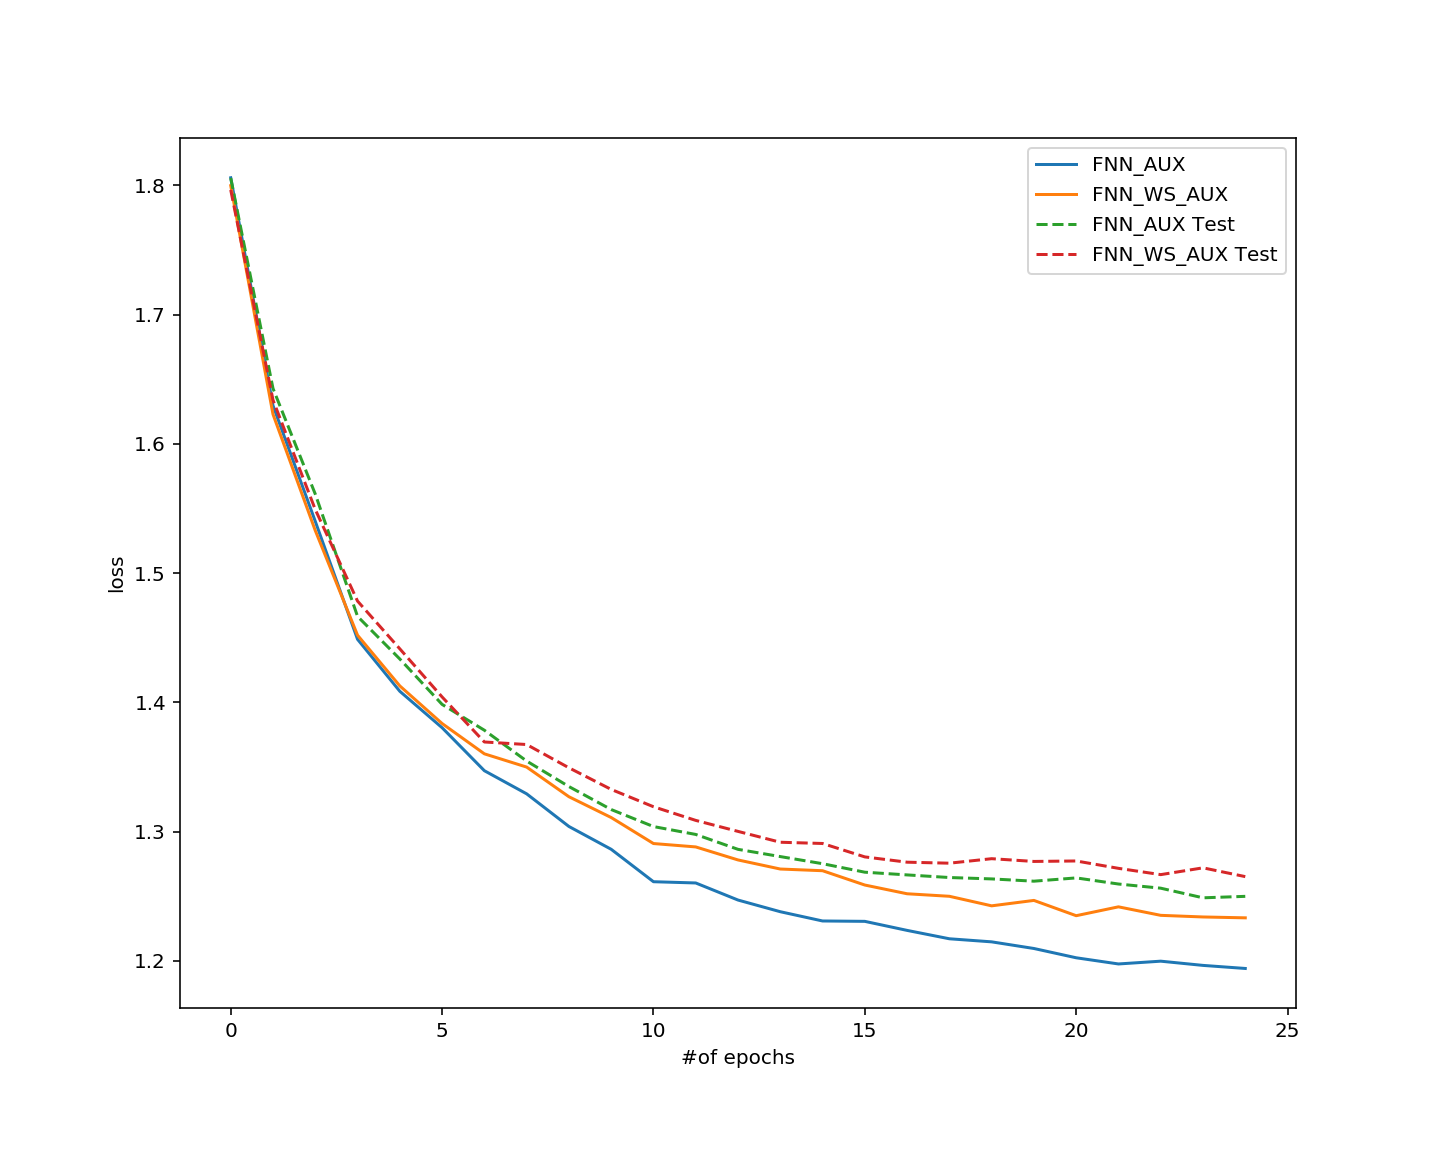

In [72]:
plotLoss(histories[2:4], '#of epochs', 'loss', curve_names[2:4])